# Group 19 - Milestone 2

## Children's Reading Assistant with Retrieval-Augmented Generation and Evaluation

This module implements a full retrieval augmented generation (RAG) system designed to support child-friendly question answering. It includes passage embedding and semantic search, GPT-based answer generation, readability evaluation, and safety monitoring. The pipeline retrieves top-k relevant passages, generates aligned responses, and assesses output quality using Flesch-Kincaid scoring, vocabulary simplicity checks, and content safety filtering to ensure developmentally appropriate responses for children ages 6 to 10.

## Install required packages

In [ ]:
!pip install --upgrade pip
!pip install sentence-transformers
!pip install openai
!pip install datasets
!pip install nltk
!pip install textstat
!pip install matplotlib
!pip install scikit-learn

## Mount Google Drive and find txt file

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pathlib import Path
data = Path("/content/drive/MyDrive/cleaned_merged_fairy_tales_without_eos.txt")

# preview content
with open(data, "r", encoding="utf-8") as f:
  for _ in range(10):
    print(f.readline().strip())

The Happy Prince.
HIGH above the city, on a tall column, stood the statue of the Happy Prince.  He was gilded all over with thin leaves of fine gold, for eyes he had two bright sapphires, and a large red ruby glowed on his sword-hilt.
He was very much admired indeed.  “He is as beautiful as a weathercock,” remarked one of the Town Councillors who wished to gain a reputation for having artistic tastes; “only not quite so useful,” he added, fearing lest people should think him unpractical, which he really was not.
“Why can’t you be like the Happy Prince?” asked a sensible mother of her little boy who was crying for the moon.  “The Happy Prince never dreams of crying for anything.”
“I am glad there is some one in the world who is quite happy,” muttered a disappointed man as he gazed at the wonderful statue.
“He looks just like an angel,” said the Charity Children as they came out of the cathedral in their bright scarlet cloaks and their clean white pinafores.
“How do you know?” said the M

## Preprocess text

To preprocess the text, it means to make it clean, consistent, and easy for the model to understand. This includes removing extra spaces, normalizing punctuation and capitalization, and splitting long passages. Then, preprocessing would improve retrieval accuracy, ensure that embeddings are reliable, help the model stay within token limits, and allow safety checks like readability and vocabulary to work correctly.

In [ ]:
import re, math
import pandas as pd

# abot how many words per passage / chunk
passage_size = 120

def passage_text(text, passage_size=passage_size):
  words = text.split()
  passages = []
  for i in range(0, len(words), passage_size):
    passage = " ".join(words[i:i+passage_size]).strip()
    if len(passage) > 20:
      passages.append(passage)
  return passages

# try to split into candidate stories
with open(data, "r", encoding="utf-8", errors="replace") as fh:
  raw = fh.read()

# split on multiple newlines
story_blocks = [b.strip() for b in re.split(r'\n{2,}', raw) if len(b.strip())>50]
print(f"Detected {len(story_blocks)} story-like blocks (heuristic)")

rows = []
for si, block in enumerate(story_blocks):
  title = f"story_{si}"
  passages = passage_text(block)
  for j, c in enumerate(passages):
    rows.append({"story_id": si, "title": title, "passage_id": f"{si}_{j}", "passage": c})

passages_df = pd.DataFrame(rows)
print("Total passages:", len(passages_df))
print()
output_dir = Path("/content/drive/MyDrive/librarian_project")
output_dir.mkdir(parents=True, exist_ok=True)
passages_df.to_csv(output_dir/"passages.csv", index=False)
passages_df.head(3)


Detected 908 story-like blocks (heuristic)
Total passages: 32033



,story_id,title,passage_id,passage
0,0,story_0,0_0,"The Happy Prince. HIGH above the city, on a ta..."
1,0,story_0,0_1,of crying for anything.” “I am glad there is s...
2,0,story_0,0_2,"behind, for he was in love with the most beaut..."


## Build embeddings

We build embeddings to convert each passage of text into a numerical vector that then captures its meaning. This would allow us to measure similarity between a user query and the passages using techniques such as cosine similarity. Embeddings are also important for retrieval-augmented generation (RAG), because they let the system find the most relevant passages to provide context to the model, reducing hallucinations and improving answer quality.

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
import torch
import time
from pathlib import Path

output_dir = Path("/content/drive/MyDrive/librarian_project")
output_dir.mkdir(parents=True, exist_ok=True)

model_name = "all-MiniLM-L6-v2"
print("Loading embedding model:", model_name)
embed_model = SentenceTransformer(model_name)

# check gpu
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
embed_model = embed_model.to(device)

passages = passages_df['passage'].tolist()
total_passages = len(passages)
print(f"Total passages: {total_passages}")

# compute embeddings with batching
batch_size = 128
embeddings = []

start_time = time.time()
for i in range(0, total_passages, batch_size):
  batch = passages[i:i+batch_size]
  batch_embeddings = embed_model.encode(
      batch,
      convert_to_numpy=True,
      show_progress_bar=False
  )
  embeddings.append(batch_embeddings)

# combine all batches
embeddings = np.vstack(embeddings)
end_time = time.time()
print("Final embeddings shape:", embeddings.shape)
print("Embedding computation time:", round(end_time - start_time, 1), "s")

# save final embeddings
np.save(output_dir / "embeddings.npy", embeddings)
passages_df.to_pickle(output_dir / "passages_meta.pkl")
print("Saved final embeddings and passages to:", output_dir)


Loading embedding model: all-MiniLM-L6-v2


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Using device: cuda
Total passages: 32033
Final embeddings shape: (32033, 384)
Embedding computation time: 61.7 s
Saved final embeddings and passages to: /content/drive/MyDrive/librarian_project


## Cosine similarity for RAG

Cosine similarity measures how similar two vectors are, based on the angle between them rather than their magnitude. In the context of RAG, we would represent both the user query and each passage as embedding vectors. Cosine similarity would then let us find which passages are most “aligned” in meaning with the query, so we can feed the top relevant passages to the model to improve its answers.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def retrieve_top_passages(query, embeddings, passages_df, top_k=3):
  query_vec = embed_model.encode([query])
  sims = cosine_similarity(query_vec, embeddings)[0]
  top_indices = sims.argsort()[-top_k:][::-1]
  return passages_df.iloc[top_indices]

## GPT 4 Query Function

We can use a GPT-4 query function to standardize how questions and retrieved passages are sent to the model. This would ensure consistent, child-friendly responses, reducing hallucinations through RAG grounding and makeing it easier to log outputs for analysis and reproducibility. It also allows flexible tuning of parameters.

In [ ]:
from google.colab import userdata
openai_api_key = userdata.get('OPENAI_API_KEY')

In [ ]:
!pip install --upgrade openai

In [ ]:
import openai

openai.api_key = openai_api_key

# define gpt query function
def ask_gpt(query, retrieved_passages, model="gpt-4o-mini", max_tokens=300, temperature=0.7):
    context_text = "\n\n".join(retrieved_passages['passage'].tolist())

    prompt = f"""
You are a friendly reading assistant for children ages 6 to 10.
Use the passages below to answer the child's question.
Always ask 1–2 follow-up questions to engage critical thinking.

Passages:
{context_text}

Child's question: {query}

Answer:
"""
    # call gpt
    response = openai.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        temperature=temperature,
        max_tokens=max_tokens
    )

    # extract and return text
    return response.choices[0].message.content.strip()

### Test system with query

In [ ]:
query = "Why do the characters in the story help each other?"
top_passages = retrieve_top_passages(query, embeddings, passages_df, top_k=3)
answer = ask_gpt(query, top_passages, model="gpt-4o-mini")
print(answer)

The characters in the story help each other because they care about one another and want to support each other during difficult times. For example, Sara helps Ermengarde feel less scared and lonely by creating a fun way to communicate through knocks on the wall. They build a friendship and share their feelings, which makes their situation a little brighter.

What do you think friendship means? Can you think of a time when you helped a friend or a friend helped you?


### Use at least 20 test queries

In [ ]:
# test queries
test_queries = [
    "Why is the princess sad?",
    "How does the main character solve problems?",
    "What lesson can we learn from this story?",
    "Why do the characters help each other?",
    "How does the hero overcome obstacles?",
    "What is the moral of the story?",
    "Why does the villain act the way they do?",
    "How do the characters change throughout the story?",
    "What is the story teaching about friendship?",
    "Why does the character make that decision?",
    "How does the setting affect the story?",
    "Which character do you like the most and why?",
    "How does the character show courage?",
    "What problems do the characters face?",
    "Why is this story important for children?",
    "How do the characters show kindness?",
    "What is the ending trying to teach us?",
    "How does the character feel when something bad happens?",
    "What would you do if you were in the story?",
    "Why does the main character feel lonely?",
    "How do the characters show bravery?",
    "What is the main problem in the story?",
    "Why do the characters trust each other?",
    "What lesson can we learn from this story?",
    "What makes the story exciting?"
]

In [ ]:
results = []
for q in test_queries:
  top_passages = retrieve_top_passages(q, embeddings, passages_df, top_k=3)
  ans = ask_gpt(q, top_passages)
  results.append({"query": q, "response": ans})

results_df = pd.DataFrame(results)
results_df.to_csv("/content/drive/MyDrive/librarian_project/test_responses.csv", index=False)

## Add readability and vocabulary checks

We add readability and vocabulary checks to make sure that the responses are age-appropriate and easy for children to understand. Readability, like using that of the Flesch-Kincaid grade, would ensure that the text matches the target grade level, while vocabulary checks would flag complex or rare words that might confuse young readers. This would help maintain safe, clear, and educational outputs.

In [ ]:
# nltk is used for "building Python programs to work with human language data"
import nltk
from textstat import flesch_kincaid_grade
import pandas as pd

# download nltk words corpus
nltk.download('words')
from nltk.corpus import words

# create set of known english words
english_words = set(w.lower() for w in words.words())

# function to check vocabulary
def check_vocab(text):
  words_in_text = set(text.lower().split())
  unknown_words = words_in_text - english_words
  return len(unknown_words), unknown_words

# enhance results
enhanced_results = []
for r in results:
  fk_grade = flesch_kincaid_grade(r["response"])
  vocab_count, vocab_words = check_vocab(r["response"])
  enhanced_results.append({
      "query": r["query"],
      "response": r["response"],
      "fk_grade": fk_grade,
      "vocab_issues_count": vocab_count,
      "vocab_issues": list(vocab_words)[:10]  # top 10 only
  })

enhanced_df = pd.DataFrame(enhanced_results)
enhanced_df.to_csv("/content/drive/MyDrive/librarian_project/test_responses_enhanced.csv", index=False)

print("Enhanced results are saved. The sample is")
print(enhanced_df.head())

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


Enhanced results are saved. The sample is
                                         query  \
0                     Why is the princess sad?   
1  How does the main character solve problems?   
2    What lesson can we learn from this story?   
3       Why do the characters help each other?   
4        How does the hero overcome obstacles?   

                                            response  fk_grade  \
0  The princess is sad because she feels lonely a...  8.228578   
1  The main character tries to solve problems by ...  6.719699   
2  One lesson we can learn from this story is the...  7.613167   
3  The characters help each other because they wa...  9.475083   
4  The hero overcomes obstacles by showing courag...  8.692552   

   vocab_issues_count                                       vocab_issues  
0                  19  [loves,, it’s, don’t, sisters, makes, isolated...  
1                  27  [trigonometry,, 2., tries, however,, doesn't, ...  
2                  10  [someone?, o

## Show which passages GPT saw

We show which passages GPT saw to make the computation transparent and reproducible. It would let us verify that the model is grounding its answers in the retrieved context rather than hallucinating. This would also help with debugging, evaluating retrieval quality, and citing sources in results.

In [ ]:
logged_results = []
for q in test_queries:
  top_passages = retrieve_top_passages(q, embeddings, passages_df, top_k=3)
  ans = ask_gpt(q, top_passages)
  top_ids = top_passages['passage_id'].tolist()
  logged_results.append({
      "query": q,
      "response": ans,
      "top1_passage_id": top_ids[0],
      "top2_passage_id": top_ids[1],
      "top3_passage_id": top_ids[2]
  })

pd.DataFrame(logged_results).to_csv("/content/drive/MyDrive/librarian_project/test_responses_logged.csv", index=False)

## Computer simple metrics

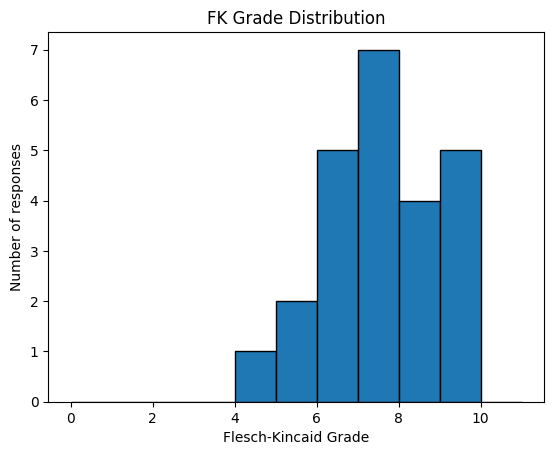

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fk_scores = enhanced_df['fk_grade']
plt.hist(fk_scores, bins=np.arange(0, 12, 1), edgecolor='black')
plt.xlabel("Flesch-Kincaid Grade")
plt.ylabel("Number of responses")
plt.title("FK Grade Distribution")
plt.show()

The FK Grade Distribution histogram above shows that most model responses fall between grades 6 and 10, indicating that the language used is slightly above the target reading level for children of ages 6 to 10. The peak occurs around grades 7 to 8, meaning the majority of responses are at a middle-school reading level. This means that there are very few responses below grade 6 or above grade 10, suggesting the responses are generally consistent in complexity.